# Criminal Homicides in 50 American Cities

![handcuffs](handcuffs.jpg)

## Background about Data
- This dataset contains 52, 179 homocides across 50 American Cities in a 5.4 MB CSV file. Records range from 2 years to 10 years worth of data for police departments
- Victim information: name, race, age, sex
- Homocide information: reported date, city, state, lat / lon, disposition
 
### How it was collected
- Reporters for The Washington Post reached out to departments and received the data in many different formats. 
- It was cleaned and cross referenced with FBI data, public records, death certificates to ensure it was as accurate as possible
- Each homicide was matched to a location
- The Washington Post followed the definitions in FBI’s Uniform Crime Reporting Program for Homocides:
    - Include murder and non-negligent manslaughter
    - Exclude suicides, accidents, justifiable homicides and deaths caused by negligence.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gmplot

In [2]:
dataset_url = "https://raw.githubusercontent.com/washingtonpost/data-homicides/master/homicide-data.csv"

df_murder = pd.read_csv(dataset_url, encoding = "ISO-8859-1")

In [3]:
# Ensure that we have the correct data
df_murder.head(10)

,uid,reported_date,victim_last,victim_first,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition
0,Alb-000001,20100504,GARCIA,JUAN,Hispanic,78,Male,Albuquerque,NM,35.095788,-106.538555,Closed without arrest
1,Alb-000002,20100216,MONTOYA,CAMERON,Hispanic,17,Male,Albuquerque,NM,35.056810,-106.715321,Closed by arrest
2,Alb-000003,20100601,SATTERFIELD,VIVIANA,White,15,Female,Albuquerque,NM,35.086092,-106.695568,Closed without arrest
3,Alb-000004,20100101,MENDIOLA,CARLOS,Hispanic,32,Male,Albuquerque,NM,35.078493,-106.556094,Closed by arrest
4,Alb-000005,20100102,MULA,VIVIAN,White,72,Female,Albuquerque,NM,35.130357,-106.580986,Closed without arrest
5,Alb-000006,20100126,BOOK,GERALDINE,White,91,Female,Albuquerque,NM,35.151110,-106.537797,Open/No arrest
6,Alb-000007,20100127,MALDONADO,DAVID,Hispanic,52,Male,Albuquerque,NM,35.111785,-106.712614,Closed by arrest
7,Alb-000008,20100127,MALDONADO,CONNIE,Hispanic,52,Female,Albuquerque,NM,35.111785,-106.712614,Closed by arrest
8,Alb-000009,20100130,MARTIN-LEYVA,GUSTAVO,White,56,Male,Albuquerque,NM,35.075380,-106.553458,Open/No arrest
9,Alb-000010,20100210,HERRERA,ISRAEL,Hispanic,43,Male,Albuquerque,NM,35.065930,-106.572288,Open/No arrest


# First Look

- We can notice that some values might need to have their datatype altered (age), and others can be one hot encoded (sex)
- We can change the reported_date datatype to an actual datetime object
- There are no duplicates

In [4]:
# Looking at the datatypes and memory usage
df_murder.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52179 entries, 0 to 52178
Data columns (total 12 columns):
uid              52179 non-null object
reported_date    52179 non-null int64
victim_last      52178 non-null object
victim_first     52179 non-null object
victim_race      52179 non-null object
victim_age       52179 non-null object
victim_sex       52179 non-null object
city             52179 non-null object
state            52179 non-null object
lat              52119 non-null float64
lon              52119 non-null float64
disposition      52179 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 29.8 MB


In [5]:
# There are no duplicates in this data set
sum(df_murder.duplicated())

0

# Some Fun

- This fun exercise actually proved to be useful. It shows that the city label cannot always be trust because we can see two murders mislabeled for San Francisco

In [20]:
# Lets only look at California
sf_murder = df_murder[(df_murder['state']=="CA") & (df_murder['city']=="San Francisco")]

# Initial focus (Tenderloin District, SF)
focus_lat = 37.7833302
focus_lon = -122.416665
gmap = gmplot.GoogleMapPlotter(focus_lat, focus_lon, 12)

# Overlay our datapoints onto the map
gmap.heatmap(sf_murder['lat'], sf_murder['lon'])

# Generate the heatmap into an HTML file
gmap.draw("my_heatmap.html")

### Viewing the resulting file: 

In [21]:
from IPython.display import IFrame
IFrame(src='./my_heatmap.html', width=700, height=600)

# Missing Values

In [22]:
for col in df_murder.columns:
    print(f"{col:20} has {df_murder[col].isnull().sum():5} missing values.")

uid                  has     0 missing values.
reported_date        has     0 missing values.
victim_last          has     1 missing values.
victim_first         has     0 missing values.
victim_race          has     0 missing values.
victim_age           has     0 missing values.
victim_sex           has     0 missing values.
city                 has     0 missing values.
state                has     0 missing values.
lat                  has    60 missing values.
lon                  has    60 missing values.
disposition          has     0 missing values.


### Geography

After seeing that there are 60 latitude values and 60 longitude values missing, we confirm that they are missing as pairs and not indivudually: 

In [23]:
# Confirm that 60 lat & lon values are missing TOGETHER
missing_lats = df_murder['lat'].isnull()
len(df_murder['lon'][missing_lats])

60

Are they missing from the same city or equally dispersed? Using lat as a key, we can see that the missing geographical coordinates are not equally distributed.

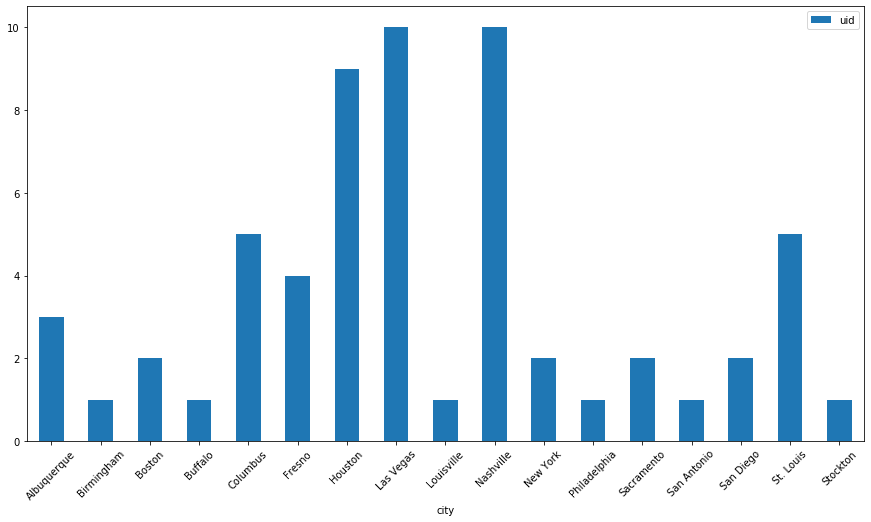

In [25]:
missing_value_counts = df_murder[missing_lats].groupby('city')[['uid']].nunique()
missing_value_counts.plot.bar(figsize=(15,8))
plt.xticks(rotation=45);

Because there are only a handful of missing values, they should not pose a problem if deleted from the dataset.

In [26]:
for ind, row in missing_value_counts.iterrows():
    print(round((row[0]/len(df_murder[df_murder['city']==ind]))*100,2),"%", ind)

0.79 % Albuquerque
0.12 % Birmingham
0.33 % Boston
0.19 % Buffalo
0.46 % Columbus
0.82 % Fresno
0.31 % Houston
0.72 % Las Vegas
0.17 % Louisville
1.3 % Nashville
0.32 % New York
0.03 % Philadelphia
0.53 % Sacramento
0.12 % San Antonio
0.43 % San Diego
0.3 % St. Louis
0.23 % Stockton


In [27]:
# Deleting missing rows
df_murder = df_murder[~missing_lats]

### Names
Losing 1 row won't make a difference either, so we will remove the no named entry.

In [28]:
df_murder = df_murder[~df_murder['victim_last'].isnull()]

# Column by Column
## reported_date
We will convert reported_date ints into datetime objects for easier readability and better compatibility with python tools for the time being

In [29]:
def get_datetime(int_date):
    int_date = str(int_date)
    day = int_date[-2:]
    month = int_date[-4:-2]
    year = int_date[:4]
    return f"{year}-{month}-{day}"

df_murder['reported_date'] = pd.to_datetime(df_murder['reported_date'].map(get_datetime))

- We can split time up into 3 different features (year, month date). But do we need all 3 features? 
- First, lets try to look at what is happening over time. As you can see, homocides are periodic and appear to have increased over the years. Therefore, it might not be wise to discard the year column. 
- Other questions to consider when encoding: When is time cyclical and not? Is Dec 31st very close to January 1st or very far?

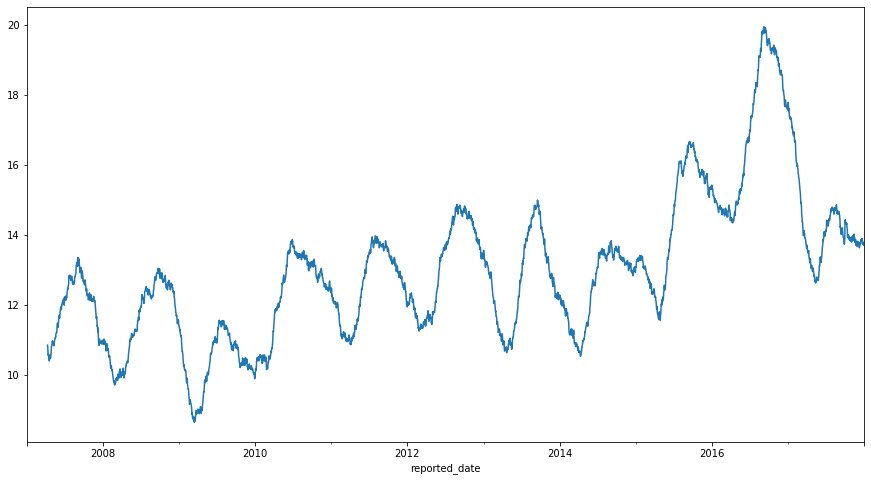

In [30]:
df_murder.groupby('reported_date').count()['uid'].rolling(100).mean().plot(figsize=(15,8));

## victim_last & victim_first

In [31]:
name_in_murder = df_murder.groupby('victim_last').count()['uid']
name_in_murder.sort_values(ascending=False).head(10)

victim_last
Unknown     5756
WILLIAMS     814
JOHNSON      808
SMITH        645
JONES        616
BROWN        589
JACKSON      445
DAVIS        422
THOMAS       350
HARRIS       297
Name: uid, dtype: int64

- The first thing that stands out is that over 10% of the last names are unknown! What are we going to do? 
- 814 people with the last name 'Williams' have been killed over the last decade! What does that mean? 
- Answer: It means nothing and we will get rid of it. 
- Both this column and victim_first are just going to be noise to the model.

![Common Last Names](common_last_names.png)

In [32]:
del df_murder['victim_last']
del df_murder['victim_first']

# victim_age
- First, we will convert age from an object data type to int
- Upon trying to do so, it doesn't work! There was an 'unknown' hidden in there

In [33]:
df_murder['victim_age'].astype('int64')

ValueError: invalid literal for int() with base 10: 'Unknown'

It looks like there are a lot of unknowns... 

In [34]:
len(df_murder[df_murder['victim_age']=='Unknown'])

2997

It looks like a lot of the reports with unknown ages have unknown sex, race, etc as well. Therefore, we will compute the mean age (per gender) in the city of the unknown age and use that as our stand in. We do this because on average males are dying 3 years younger than females.

In [35]:
known_age_data = df_murder[df_murder['victim_age']!="Unknown"].copy()

known_age_female = known_age_data[known_age_data['victim_sex']=='Female']
known_age_male = known_age_data[known_age_data['victim_sex']=='Male']

dict_of_age_means = {}
dict_of_age_means['Female'] = {}
dict_of_age_means['Male'] = {}

for city in known_age_female['city'].unique():
    mean_age = round(known_age_female[known_age_female['city']==city]['victim_age'].astype('int64').mean()).astype('int64')
    dict_of_age_means['Female'][city] = mean_age
    
for city in known_age_male['city'].unique():
    mean_age = round(known_age_male[known_age_male['city']==city]['victim_age'].astype('int64').mean()).astype('int64')
    dict_of_age_means['Male'][city] = mean_age
    
# Just in case sex isnt known, we default to total mean of data:
total_mean = int(known_age_data['victim_age'].astype('int64').mean())

In [36]:
def get_mean_age(row):
    if row['victim_age'] == "Unknown":
        if row['victim_sex'] != "Unknown":
            return dict_of_age_means[row['victim_sex']][row['city']]
        else:
            return total_mean
    else:
        return row['victim_age']
    
df_murder['victim_age'] = df_murder.apply(get_mean_age, axis=1).astype('int64')

Check for outliers

In [37]:
mean = df_murder['victim_age'].mean()
std = 3*df_murder['victim_age'].std()

print(mean, std)

31.769484631029588 41.98646766189355


In [38]:
df_murder[(df_murder['victim_age'] < 5)].head(5)

,uid,reported_date,victim_race,victim_age,victim_sex,city,state,lat,lon,disposition
28,Alb-000029,2010-07-26,Asian,1,Female,Albuquerque,NM,35.064456,-106.524458,Closed without arrest
32,Alb-000033,2010-08-20,Other,3,Female,Albuquerque,NM,35.072245,-106.570492,Closed by arrest
33,Alb-000034,2010-08-22,Hispanic,1,Male,Albuquerque,NM,35.073400,-106.695892,Closed by arrest
52,Alb-000053,2011-04-13,Other,2,Male,Albuquerque,NM,35.061363,-106.568493,Closed by arrest
67,Alb-000068,2011-08-25,White,0,Male,Albuquerque,NM,35.085033,-106.711680,Closed by arrest


If we look at a 10 binned histogram, there doesnt appear to be anything out of the ordinary

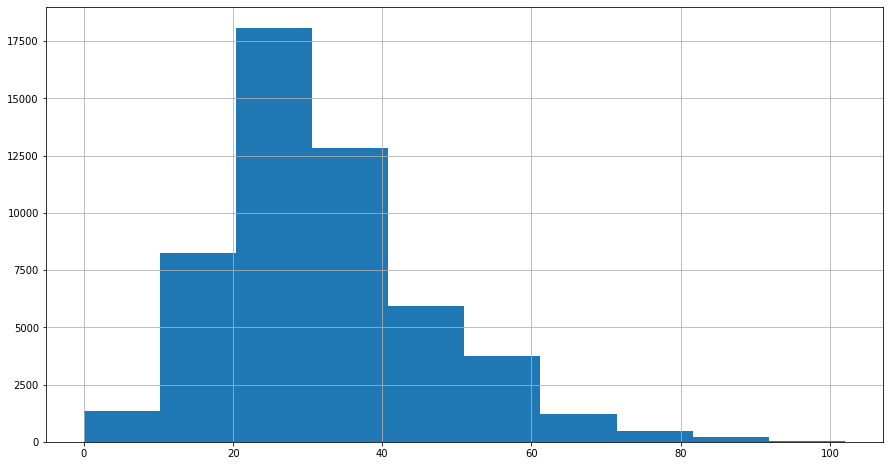

In [39]:
df_murder['victim_age'].hist(bins=10, figsize=(15,8));

However, after increasing the granularity, we can see where we inserted our means

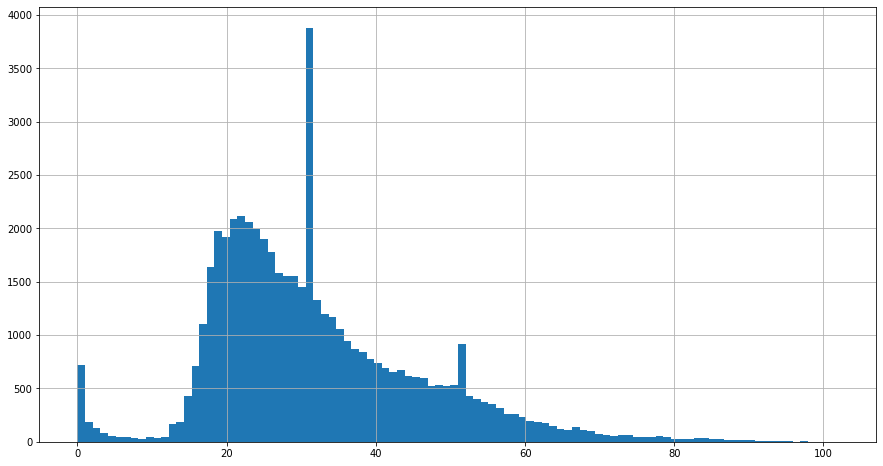

In [40]:
df_murder['victim_age'].hist(bins=100, figsize=(15,8));

This is not an acceptable solution. We will instead choose to discard the rows without age information

In [41]:
df_murder = df_murder[~(df_murder['victim_age']=='Unknown')]

/home/nahal/anaconda3/envs/7gate/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Normalize Ages

In [48]:
xmax = df_murder['victim_age'].max()
xmin = df_murder['victim_age'].min()

f = lambda x: (x-xmin) / (xmax-xmin)

df_murder['victim_age'] = df_murder['victim_age'].map(f)   

# Cities
There are no unknowns.

In [49]:
len(df_murder['city'].unique())

50

### Curse of Dimensionality
- Do we one hot encode this? Suddenly we are introducing 5x more features. Cities are tricky. There are fifty of them and they have no real order. However, we could come up with our own way to order a city (through population size for example). 
- For now, we will just assign a value 0 to 50 to each city

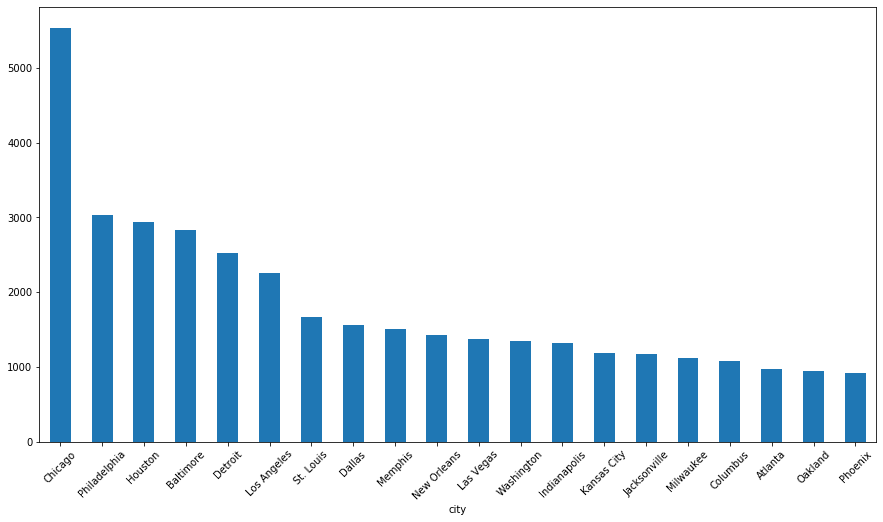

In [50]:
df_murder.groupby('city').count()['uid'].sort_values(ascending=False).head(20).plot(kind='bar', figsize=(15,8));
plt.xticks(rotation=45);

In [51]:
encoded_cities_dict = {k: v for k,v in zip(df_murder['city'].unique(),list(range(1,len(df_murder['city'].unique())+1)))}

def encode_city(x):
    return encoded_cities_dict[x]

In [52]:
df_murder['city'] = df_murder['city'].apply(encode_city)

### Normalize Cities

In [53]:
xmax = df_murder['city'].max()
xmin = df_murder['city'].min()

f = lambda x: (x-xmin) / (xmax-xmin)

df_murder['city'] = df_murder['city'].map(f)

# States
We will treat states as we treated cities earlier

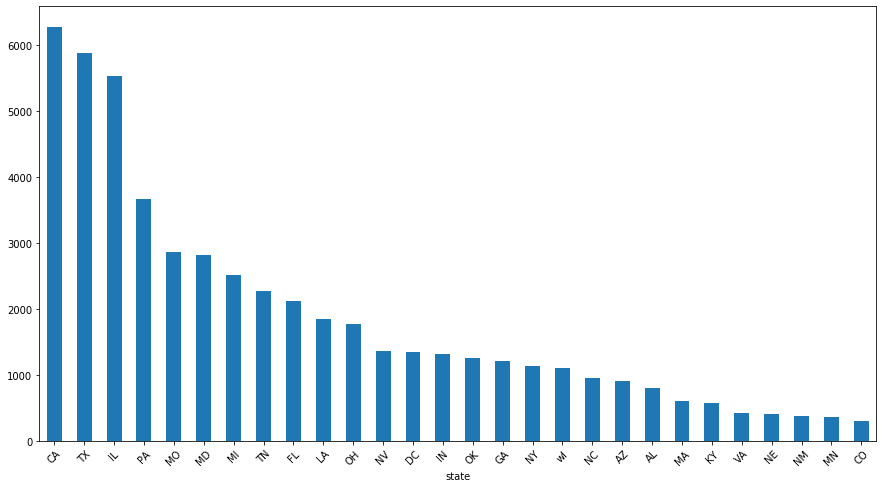

In [54]:
df_murder.groupby('state').count()['uid'].sort_values(ascending=False).plot(kind='bar', figsize=(15,8));
plt.xticks(rotation=45);

In [55]:
encoded_states_dict = {k: v for k,v in zip(df_murder['state'].unique(),list(range(1,len(df_murder['state'].unique())+1)))}
def encode_state(x):
    return encoded_states_dict[x]

In [56]:
df_murder['state'] = df_murder['state'].apply(encode_state)

In [57]:
xmax = df_murder['state'].max()
xmin = df_murder['state'].min()

f = lambda x: (x-xmin) / (xmax-xmin)

df_murder['state'] = df_murder['state'].map(f)

# victim_race
We see a lot of unknowns, and we choose to get rid of them. We then one hot encode this column.

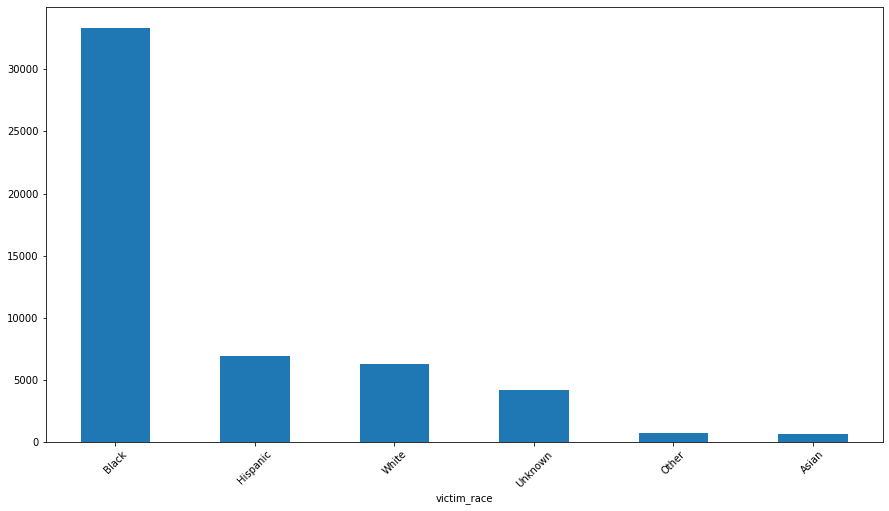

In [59]:
df_murder.groupby('victim_race').count()['uid'].sort_values(ascending=False).plot(kind='bar', figsize=(15,8));
plt.xticks(rotation=45);

In [60]:
df_murder = df_murder[~(df_murder['victim_race']=='Unknown')]

In [61]:
df_murder = df_murder.join(pd.get_dummies(df_murder['victim_race']))

In [62]:
del df_murder['victim_race']
df_murder.head(5)

,uid,reported_date,victim_age,victim_sex,city,state,lat,lon,disposition,Asian,Black,Hispanic,Other,White
0,Alb-000001,2010-05-04,0.764706,Male,0.0,0.0,35.095788,-106.538555,Closed without arrest,0,0,1,0,0
1,Alb-000002,2010-02-16,0.166667,Male,0.0,0.0,35.056810,-106.715321,Closed by arrest,0,0,1,0,0
2,Alb-000003,2010-06-01,0.147059,Female,0.0,0.0,35.086092,-106.695568,Closed without arrest,0,0,0,0,1
3,Alb-000004,2010-01-01,0.313725,Male,0.0,0.0,35.078493,-106.556094,Closed by arrest,0,0,1,0,0
4,Alb-000005,2010-01-02,0.705882,Female,0.0,0.0,35.130357,-106.580986,Closed without arrest,0,0,0,0,1


# victim_sex


There are fewer unknowns because of our earlier cleaning. Still, we will delete unknown values and then one hot encode this column.

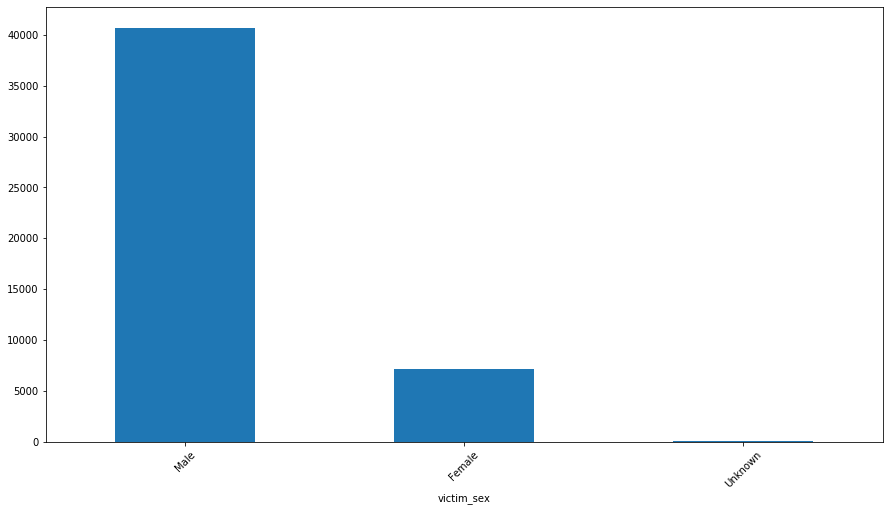

In [64]:
df_murder.groupby('victim_sex').count()['uid'].sort_values(ascending=False).plot(kind='bar', figsize=(15,8));
plt.xticks(rotation=45);

In [65]:
df_murder = df_murder[~(df_murder['victim_sex']=='Unknown')]

In [66]:
df_murder = df_murder.join(pd.get_dummies(df_murder['victim_sex']))

In [67]:
del df_murder['victim_sex']
df_murder.head(5)

,uid,reported_date,victim_age,city,state,lat,lon,disposition,Asian,Black,Hispanic,Other,White,Female,Male
0,Alb-000001,2010-05-04,0.764706,0.0,0.0,35.095788,-106.538555,Closed without arrest,0,0,1,0,0,0,1
1,Alb-000002,2010-02-16,0.166667,0.0,0.0,35.056810,-106.715321,Closed by arrest,0,0,1,0,0,0,1
2,Alb-000003,2010-06-01,0.147059,0.0,0.0,35.086092,-106.695568,Closed without arrest,0,0,0,0,1,1,0
3,Alb-000004,2010-01-01,0.313725,0.0,0.0,35.078493,-106.556094,Closed by arrest,0,0,1,0,0,0,1
4,Alb-000005,2010-01-02,0.705882,0.0,0.0,35.130357,-106.580986,Closed without arrest,0,0,0,0,1,1,0


# Disposition
We will one hot encode Disposition. There are three different categories.

In [68]:
df_murder = df_murder.join(pd.get_dummies(df_murder['disposition']))
del df_murder['disposition']
df_murder.head(5)

,uid,reported_date,victim_age,city,state,lat,lon,Asian,Black,Hispanic,Other,White,Female,Male,Closed by arrest,Closed without arrest,Open/No arrest
0,Alb-000001,2010-05-04,0.764706,0.0,0.0,35.095788,-106.538555,0,0,1,0,0,0,1,0,1,0
1,Alb-000002,2010-02-16,0.166667,0.0,0.0,35.056810,-106.715321,0,0,1,0,0,0,1,1,0,0
2,Alb-000003,2010-06-01,0.147059,0.0,0.0,35.086092,-106.695568,0,0,0,0,1,1,0,0,1,0
3,Alb-000004,2010-01-01,0.313725,0.0,0.0,35.078493,-106.556094,0,0,1,0,0,0,1,1,0,0
4,Alb-000005,2010-01-02,0.705882,0.0,0.0,35.130357,-106.580986,0,0,0,0,1,1,0,0,1,0


# LAT and LON

Since there was a negative in lon, I took the absolute value before normalizing it.

In [69]:
df_murder['lon'] = abs(df_murder['lon'])

for coord in ['lat', 'lon']:
    xmax = df_murder[coord].max()
    xmin = df_murder[coord].min()

    f = lambda x: (x-xmin) / (xmax-xmin)

    df_murder[coord] = df_murder[coord].map(f)

# Final Data

In [70]:
df_murder.head(10)

,uid,reported_date,victim_age,city,state,lat,lon,Asian,Black,Hispanic,Other,White,Female,Male,Closed by arrest,Closed without arrest,Open/No arrest
0,Alb-000001,2010-05-04,0.764706,0.0,0.0,0.484869,0.689895,0,0,1,0,0,0,1,0,1,0
1,Alb-000002,2010-02-16,0.166667,0.0,0.0,0.482853,0.693328,0,0,1,0,0,0,1,1,0,0
2,Alb-000003,2010-06-01,0.147059,0.0,0.0,0.484368,0.692944,0,0,0,0,1,1,0,0,1,0
3,Alb-000004,2010-01-01,0.313725,0.0,0.0,0.483974,0.690236,0,0,1,0,0,0,1,1,0,0
4,Alb-000005,2010-01-02,0.705882,0.0,0.0,0.486658,0.690719,0,0,0,0,1,1,0,0,1,0
5,Alb-000006,2010-01-26,0.892157,0.0,0.0,0.487732,0.689881,0,0,0,0,1,1,0,0,0,1
6,Alb-000007,2010-01-27,0.509804,0.0,0.0,0.485697,0.693276,0,0,1,0,0,0,1,1,0,0
7,Alb-000008,2010-01-27,0.509804,0.0,0.0,0.485697,0.693276,0,0,1,0,0,1,0,1,0,0
8,Alb-000009,2010-01-30,0.549020,0.0,0.0,0.483813,0.690185,0,0,0,0,1,0,1,0,0,1
9,Alb-000010,2010-02-10,0.421569,0.0,0.0,0.483324,0.690551,0,0,1,0,0,0,1,0,0,1


In [71]:
df_murder.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47859 entries, 0 to 52178
Data columns (total 17 columns):
uid                      47859 non-null object
reported_date            47859 non-null datetime64[ns]
victim_age               47859 non-null float64
city                     47859 non-null float64
state                    47859 non-null float64
lat                      47859 non-null float64
lon                      47859 non-null float64
Asian                    47859 non-null uint8
Black                    47859 non-null uint8
Hispanic                 47859 non-null uint8
Other                    47859 non-null uint8
White                    47859 non-null uint8
Female                   47859 non-null uint8
Male                     47859 non-null uint8
Closed by arrest         47859 non-null uint8
Closed without arrest    47859 non-null uint8
Open/No arrest           47859 non-null uint8
dtypes: datetime64[ns](1), float64(5), object(1), uint8(10)
memory usage: 7.3 MB


# Conclusion
- This was surprisingly difficult without domain knowledge. 
- A lot of assumptions had to be made, where I did not know how they would fully impact analysis.
- Visual inspection can be very beneficial (map exercise)